In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv("/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv")

In [ ]:
data.head()

In [ ]:
data.info()

<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

In [ ]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

In [ ]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [ ]:
dataset_train = train_data.Open.values
dataset_train.shape

In [ ]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

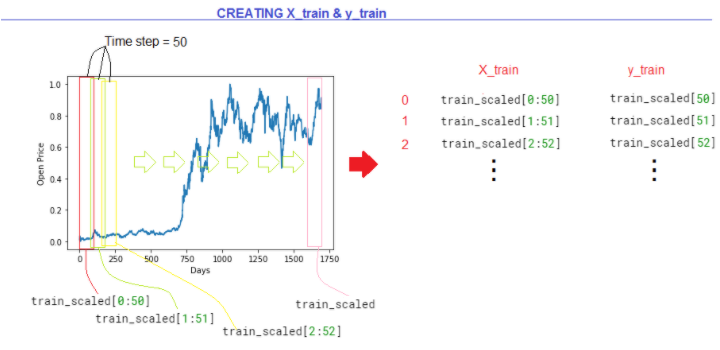

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

## Reshape

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [ ]:
X_train[0]

* Check the first item in y_train
* It is the price of 50th day

In [ ]:
y_train[0]

<a id="6"></a>
## 6.Creating RNN model 

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

<a id="7"></a>
## 7.Evaluating Model

In [ ]:
# Losses
history.history["loss"]

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data 

In [ ]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

In [ ]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data 

### Converting array and scaling

In [ ]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

### Creating X_test and y_test

In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [ ]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

### Reshape

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [ ]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

<a id="9"></a>
## 9.Evaluating with Validation Data 

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [ ]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


<a id="11"></a>
## 11.Evaluating LSTM Model

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [ ]:
data.iloc[-1]

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [ ]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

In [ ]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

## Thanks for reading, please upvote:)